## Visualizing single cell examples for pooled data
- Inputs are:
  - REQUIRED:
    -  **Input_gene_or_guide** - (str), it can be a string of gene symbol or guide (20 chars)
        - e.g., 'KRT28' or 'GTTGAAGAGCTAGATCAACG'
    -  **batch_name** - (str) batch name
        - e.g., '20200805_A549_WG_Screen' 
    - **rootDir** - image, metadata and overlays address is following the structure of dirs in the s3 bucket so we need to fix the root directory and everything else is being formed accroding to the s3 bucket structure 
        - e.g., '/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/'
  - OPTIONAL:
    -  **n_cells** - (int), number of single cells to be visualized, it is ignored if cell_selection_method is geometric_median
    -  **box_size** - (int), size of box in pixels for cropping a cell    
    -  **channels** - (list), list of channels you want to plot
        - e.g., ['DNA','Mito','Phalloidin','WGA','ER','Outline'] 
    -  **cell_selection_method** - (str) can be one of the following methods
        - random - generate n randomly selected cells
        - representative - clusters the data and sample from the "closest to mean cluster"
        - geometric_median - plots single sample than is the geometric median of samples
        
        
###  Run time:

- For random cells (n_cells=6) -> ~ 3-4 mins
- For representative cells (For )  -> ~ 3-4 mins
- For geometric median (for calculate the gm from 1500 random subset of total cells) -> ~ 3 mins
  

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
from sklearn import preprocessing
import matplotlib.pyplot as plt
# from utils import read_data, visualize_data
from utils.read_data import *
from utils.visualize_data import *
from sklearn.cluster import KMeans
import pooled_cell_painting_single_cell_visualization
import time
import gc

## Visualize single cells for the input gene of guide

In [1]:
%%time

input_gene_or_guide='KRT28'
# input_gene_or_guide='GTTGAAGAGCTAGATCAACG'

# ########################## set directories
## CP186
# batch='20200805_A549_WG_Screen';

## CP257
batch='20210422_6W_CP257';


########################## set directories
rootDir='/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/'

batch_multi_name_dict={'20210422_6W_CP257':'CP257-HeLa-WG',\
                       '20200805_A549_WG_Screen':'CP186-A549-WG'}
batchName2=batch_multi_name_dict[batch]
sc_files_dir=rootDir+'workspace/software/'+batchName2+'/data/1.profiles/'+batch+'/single_cell/\
single_cell_by_guide/'
im_size=5500 # hardcoded for now, TODO: create a dictionary if this number is different for 257 vs 186

#################### options for parameters to set
n_cells=6
box_size=100

# how we select cells which can be 'random','representative','geometric_median'
cell_selection_method='geometric_median'

channels=['DNA','Mito','Phalloidin','WGA','ER','Outline']

##################### read metadata and create the file name for input guide or gene
metadata_dir=rootDir+'workspace/metadata/'+batch+'/'
metadata_orig= pd.read_csv(metadata_dir+'Barcodes.csv')

input_matched_rows = metadata_orig[(metadata_orig['gene_symbol']==input_gene_or_guide) | (metadata_orig['sgRNA']==input_gene_or_guide)]
gene=input_matched_rows.gene_symbol.unique().tolist()[0]
guides_ls=input_matched_rows.sgRNA.unique().tolist()

all_guides_gms_ls=[]
# gene_guids_ls=glob.glob(sc_files_dir+'*_'+input_gene+'.csv.gz')
gene_guids_ls=[sc_files_dir+batch+'_single_cell_normalized_ALLBATCHES__'+gi+'_'+gene+'.csv.gz' for gi in guides_ls]

for gi in gene_guids_ls:
    df_p_s=pd.read_csv(gi);

    for ch in channels:
        df_p_s["PathName_Corr"+ch]=rootDir+batch+'/images_corrected_cropped/'+df_p_s["Metadata_Foci_plate"]+'_'+df_p_s["Metadata_Foci_well"]+'/Corr'+ch
        df_p_s["FileName_Corr"+ch]="Corr"+ch+"_"+"Site_"+df_p_s["Metadata_Foci_site_location"].astype(str)+".tiff"

    df_p_s["Path_Outlines"]=rootDir+'workspace/analysis/'+batch+'/'+df_p_s["Metadata_Foci_plate"]+'-'+df_p_s["Metadata_Foci_well"]+'-'+df_p_s["Metadata_Foci_site_location"].astype(str)+'/'\
    +'/CorrDNA_Site_'+df_p_s["Metadata_Foci_site_location"].astype(str)+'_Overlay.png'

    df_p_s["Nuclei_Location_Center_X"]=df_p_s["Cells_AreaShape_Center_X"];
    df_p_s["Nuclei_Location_Center_Y"]=df_p_s["Cells_AreaShape_Center_Y"];

    df_p_s=edgeCellFilter2(df_p_s,im_size,box_size/2);

    if df_p_s.shape[0]>0:
        df_samples,cp_features_analysis = extract_single_cell_samples(df_p_s.sample(n = np.min([1500,df_p_s.shape[0]]),\
                        replace = False).reset_index(drop=True),n_cells,cell_selection_method);
        all_guides_gms_ls.append(df_samples)

df_p_s_all=pd.concat(all_guides_gms_ls,ignore_index=True).drop_duplicates(ignore_index=True)    

if len(gene_guids_ls)>1 and df_p_s_all.shape[0]>n_cells:
    df_samples=df_p_s_all.sample(n = np.min([n_cells,df_p_s_all.shape[0]]),replace = False).reset_index(drop=True)
    
else:
    df_samples=df_p_s_all.copy()

################  visualize cells

f=visualize_n_SingleCell_pooled(channels,df_samples,box_size,im_size,title=input_gene_or_guide+'_'+cell_selection_method);

NameError: name 'pd' is not defined

In [ ]:
# df_samples
# f=visualize_n_SingleCell_pooled(channels,df_samples,box_size,im_size,title=input_gene_or_guide+'_'+cell_selection_method);

In [ ]:
np.__version__

In [ ]:
# visualize_n_SingleCell_pooled(channels,df_samples,box_size,im_size,title=cell_selection_method);
# df_samples
# df_p_s

In [ ]:
df_p_s[df_p_s.columns[df_p_s.columns.str.contains('Alig')]]

In [ ]:
def pooled_cell_painting_single_cell_visualization(input_gene_or_guide,batch,rootDir,\
            n_cells=6,box_size=100,channels=['DNA','Mito','Phalloidin','WGA','ER','Outline'],\
                                                   cell_selection_method='random'):
    

    ########################## set directories
#     batch='20200805_A549_WG_Screen';
#     rootDir='/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/'
    sc_files_dir=rootDir+'workspace/software/CP186-A549-WG/data/1.profiles/20200805_A549_WG_Screen/single_cell/single_cell_by_guide/'

    im_size=5500 # hardcoded for now, TODO: create a dictionary if this number is different for 257

    ##################### read metadata and create the file name for input guide or gene
    metadata_dir=rootDir+'workspace/metadata/'+batch+'/'
    metadata_orig= pd.read_csv(metadata_dir+'Barcodes.csv')

    input_matched_rows = metadata_orig[(metadata_orig['gene_symbol']==input_gene_or_guide) | (metadata_orig['sgRNA']==input_gene_or_guide)]
    gene=input_matched_rows.gene_symbol.unique().tolist()[0]
    guides_ls=input_matched_rows.sgRNA.unique().tolist()

    all_guides_gms_ls=[]
    # gene_guids_ls=glob.glob(sc_files_dir+'*_'+input_gene+'.csv.gz')
    gene_guids_ls=[sc_files_dir+batch+'_single_cell_normalized_ALLBATCHES__'+gi+'_'+gene+'.csv.gz' for gi in guides_ls]

    for gi in gene_guids_ls:
        df_p_s=pd.read_csv(gi);

        for ch in channels:
            df_p_s["PathName_Corr"+ch]=rootDir+batch+'/images_corrected_cropped/'+df_p_s["Metadata_Foci_plate"]+'_'+df_p_s["Metadata_Foci_well"]+'/Corr'+ch
            df_p_s["FileName_Corr"+ch]="Corr"+ch+"_"+"Site_"+df_p_s["Metadata_Foci_site_location"].astype(str)+".tiff"

        df_p_s["Path_Outlines"]=rootDir+'workspace/analysis/'+batch+'/'+df_p_s["Metadata_Foci_plate"]+'-'+df_p_s["Metadata_Foci_well"]+'-'+df_p_s["Metadata_Foci_site_location"].astype(str)+'/'\
        +'/CorrDNA_Site_'+df_p_s["Metadata_Foci_site_location"].astype(str)+'_Overlay.png'

        df_p_s["Nuclei_Location_Center_X"]=df_p_s["Cells_AreaShape_Center_X"];
        df_p_s["Nuclei_Location_Center_Y"]=df_p_s["Cells_AreaShape_Center_Y"];

        df_p_s=edgeCellFilter2(df_p_s,im_size,box_size/2);

        if df_p_s.shape[0]>0:
            df_samples,cp_features_analysis = extract_single_cell_samples(df_p_s.sample(n = np.min([1500,df_p_s.shape[0]]),\
                            replace = False).reset_index(drop=True),n_cells,cell_selection_method);
            all_guides_gms_ls.append(df_samples)

    df_p_s_all=pd.concat(all_guides_gms_ls,ignore_index=True).drop_duplicates(ignore_index=True)    

    if len(gene_guids_ls)>1 and df_p_s_all.shape[0]>n_cells:
        df_samples=df_p_s_all.sample(n = np.min([n_cells,df_p_s_all.shape[0]]),replace = False).reset_index(drop=True)

    else:
        df_samples=df_p_s_all.copy()

    ################  visualize cells

    return visualize_n_SingleCell_pooled(channels,df_samples,box_size,im_size,title=input_gene_or_guide+'_'+cell_selection_method);


input_gene_or_guide='KRT28'
# input_gene_or_guide='GTTGAAGAGCTAGATCAACG'

batch='20200805_A549_WG_Screen';
rootDir='/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/'


pooled_cell_painting_single_cell_visualization(input_gene_or_guide,batch,rootDir);

In [ ]:
# metadaDataFiles
# metadata_orig
# df_p_s.columns
# df_p_s[df_p_s.eq(5500).any(1)]

In [ ]:
# os.listdir("/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/workspace/software/CP257-HeLa-WG/data/1.profiles/20210422_6W_CP257/single_cell/")

In [ ]:
# python restore_intelligent.py imaging-platform "projects/2015_10_05_DrugRepurposing_AravindSubramanian_GolubLab_Broad/workspace/backend/2016_04_01_a549_48hr_batch1/SQ00015195/"

### Read single cell data per guide takes ~1 mins

In [ ]:
%%time
file_name='/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/workspace/\
software/CP186-A549-WG/data/1.profiles/20200805_A549_WG_Screen/single_cell/\
single_cell_by_guide/20200805_A549_WG_Screen_single_cell_normalized_ALLBATCHES__GTTGAAGAGCTAGATCAACG_KRT28.csv.gz'
df_p_s0=pd.read_csv(file_name);
df_p_s0.head()

In [ ]:
# df_p_s0[df_p_s0.columns[df_p_s0.columns.str.contains('utline')]]
# df_p_s0.columns[df_p_s0.columns.str.contains('uid')]

In [ ]:
# df_p_s0['Cells_AreaShape_Center_X'].describe()

In [ ]:
# visualize_n_SingleCell_pooled(channels,df_samples,box_size,im_size,title=cell_selection_method);

### Unarchive needed data

In [ ]:
# def unarchive_file(f2unarchive,bucket_name,user_profile):
#     """
#     unarchive input file

#     Inputs:
#     bucket_name: eg, pooled-cell-painting, imaging-plateform
#     user_profile: profile name that is used for accessing the above bucket (check in sudo vim ~/.aws/credentials)
#     proj_path: path to the project eg,2018_11_20_Periscope_Calico/workspace/analysis/

#     output:
#     command to run
#     """

#     cmd='aws s3api  restore-object  --profile '+user_profile+\
#             ' --bucket '+bucket_name+'  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/'+f2unarchive+'   --restore-request GlacierJobParameters={"Tier"="Standard"}'
#     return cmd
import os
user_profile='calico'
bucket_name='pooled-cell-painting'
rootDir='/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/'
# for p in plates:
#     for w in wells:
#         for s in sites:
# batch='20200805_A549_WG_Screen';

batch='20210422_6W_CP257'
plate_well_dirs_ls=os.listdir(rootDir+'/workspace/analysis/'+batch)
for di in plate_well_dirs_ls:
    f2unarchive='workspace/analysis/'+batch+'/'+di+'/CorrDNA_Site_'+di.split('-')[-1]+'_Overlay.png'
    if os.path.exists(rootDir+f2unarchive):
        cmd='aws s3api  restore-object  --profile '+user_profile+\
        ' --bucket '+bucket_name+'  --key projects/2018_11_20_Periscope_Calico/'+\
        f2unarchive+'   --restore-request GlacierJobParameters={"Tier"="Standard"}'
        print(cmd)
        os.system(cmd)

In [ ]:
# unarchive image folders
plate_well_ls=os.listdir('/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/20210422_6W_CP257/images_corrected_cropped')
# python restore_intelligent.py pooled-cell-painting "projects/2018_11_20_Periscope_Calico/20200805_A549_WG_Screen/images_corrected_cropped/"
channels=['DNA','Mito','Phalloidin','WGA','ER']

for pli in plate_well_ls:
    for chi in channels:
        os.system('python ~/imaging-backup-scripts/restore_intelligent.py pooled-cell-painting "projects/2018_11_20_Periscope_Calico/20210422_6W_CP257/images_corrected_cropped/'+\
pli+'/Corr'+chi+'"')

In [ ]:
plate_well_dirs_ls[0].split('-')[-1]

In [ ]:
# plate_well_ls

## Plot geometric median of all guides of an input gene

In [11]:
import glob
rootDir='/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/'

# batch='20200805_A549_WG_Screen';
batch='20210422_6W_CP257';


batch_multi_name_dict={'20210422_6W_CP257':'CP257-HeLa-WG',\
                   '20200805_A549_WG_Screen':'CP186-A549-WG'}
batchName2=batch_multi_name_dict[batch]
sc_files_dir=rootDir+'workspace/software/'+batchName2+'/data/1.profiles/'+batch+'/single_cell/single_cell_by_guide/'
im_size=5500 # hardcoded for now, TODO: create a dictionary if this number is different for 257 vs 186

### metadata 
metadata_dir=rootDir+'workspace/metadata/'+batch+'/'
metadata_orig= pd.read_csv(metadata_dir+'Barcodes.csv')

# input_gene='KRT28'
n_cells=10
box_size=100

# how we select cells which can be 'random','representative','geometric_median'
cell_selection_method='random'
channels=['DNA','Mito','Phalloidin','WGA','ER','Outline']

genes_ls=metadata_orig.gene_symbol.unique().tolist()

for igi in range(70,len(genes_ls)):
    input_gene=genes_ls[igi]
    all_guides_gms_ls=[]
    gene_guids_ls=glob.glob(sc_files_dir+'*_'+input_gene+'.csv.gz')
    for gi in gene_guids_ls:
        df_p_s=pd.read_csv(gi);
        
        for ch in channels:
            df_p_s["PathName_Corr"+ch]=rootDir+batch+'/images_corrected_cropped/'+df_p_s["Metadata_Foci_plate"]+'_'+df_p_s["Metadata_Foci_well"]+'/Corr'+ch
            df_p_s["FileName_Corr"+ch]="Corr"+ch+"_"+"Site_"+df_p_s["Metadata_Foci_site_location"].astype(str)+".tiff"

        df_p_s["Path_Outlines"]=rootDir+'workspace/analysis/'+batch+'/'+df_p_s["Metadata_Foci_plate"]+'-'+df_p_s["Metadata_Foci_well"]+'-'+df_p_s["Metadata_Foci_site_location"].astype(str)+'/'\
        +'/CorrDNA_Site_'+df_p_s["Metadata_Foci_site_location"].astype(str)+'_Overlay.png'

        df_p_s["Nuclei_Location_Center_X"]=df_p_s["Cells_AreaShape_Center_X"];
        df_p_s["Nuclei_Location_Center_Y"]=df_p_s["Cells_AreaShape_Center_Y"];
        
        df_p_s=edgeCellFilter2(df_p_s,im_size,box_size/2);

        if df_p_s.shape[0]>0:
            df_samples,cp_features_analysis = extract_single_cell_samples(df_p_s.sample(n = np.min([1500,df_p_s.shape[0]]),\
                            replace = False).reset_index(drop=True),n_cells,cell_selection_method);
            all_guides_gms_ls.append(df_samples)

    all_guides_gms_df=pd.concat(all_guides_gms_ls,ignore_index=True).drop_duplicates(ignore_index=True)
    
    if all_guides_gms_df.shape[0]==1:
        all_guides_gms_df=pd.concat([all_guides_gms_df]*2, ignore_index=True)    
    
    fig=visualize_n_SingleCell_pooled(channels,all_guides_gms_df,box_size,im_size,title=input_gene+'_'+cell_selection_method);

    
    resultsDir='/home/ubuntu/bucket/projects/2018_11_20_Periscope_Calico/workspace/visualizations/'+batch+'/geometric_median_guide_level/'
    fig.savefig(resultsDir+input_gene+'.png')  
    plt.ioff()

MTRNR2L7_geometric_median
CMC2_geometric_median
TRPC5OS_geometric_median
TRAPPC2_geometric_median
SMIM11_geometric_median
HTN1_geometric_median
SPINT4_geometric_median
TMSB15B_geometric_median
ATP5E_geometric_median
SUB1_geometric_median
GYPE_geometric_median
APELA_geometric_median
DEFB110_geometric_median
C1D_geometric_median
SREK1IP1_geometric_median
IGIP_geometric_median
DEFB121_geometric_median
POLR2K_geometric_median
SPINK9_geometric_median


 /home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/utils/visualize_data.py:374: UserWarning:Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.


CFL2_geometric_median
RPL38_geometric_median
LSM6_geometric_median


KeyboardInterrupt: 

In [ ]:
df_p_s=pd.read_csv(gi);
df_p_s["Nuclei_Location_Center_X"]=df_p_s["Cells_AreaShape_Center_X"];
df_p_s["Nuclei_Location_Center_Y"]=df_p_s["Cells_AreaShape_Center_Y"];
df_p_s=edgeCellFilter2(df_p_s,im_size,box_size/2);
# df_p_s.shape

In [ ]:
# genes_ls.index('LOC653602')
# pd.concat([all_guides_gms_df]*2, ignore_index=True)
len(genes_ls)

In [12]:
igi,input_gene,all_guides_gms_df.shape,gene_guids_ls

(92,
 'C12orf75',
 (4, 3793),
 ['/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/workspace/software/CP257-HeLa-WG/data/1.profiles/20210422_6W_CP257/single_cell/single_cell_by_guide/20210422_6W_CP257_single_cell_normalized_ALLBATCHES__AACTCCACCGCCACCAGCGC_C12orf75.csv.gz',
  '/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/workspace/software/CP257-HeLa-WG/data/1.profiles/20210422_6W_CP257/single_cell/single_cell_by_guide/20210422_6W_CP257_single_cell_normalized_ALLBATCHES__CATCTTTGGCTGCTCCTGCA_C12orf75.csv.gz',
  '/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/workspace/software/CP257-HeLa-WG/data/1.profiles/20210422_6W_CP257/single_cell/single_cell_by_guide/20210422_6W_CP257_single_cell_normalized_ALLBATCHES__CCGTAACAGAAGATGACAAG_C12orf75.csv.gz',
  '/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/workspace/software/CP257-HeLa-WG/data/1.profiles/20210422_6W_CP257/single_cell/single_cell_by_guide/20210422_6W_CP257_single_cell_normalized_A

In [ ]:
os.system('mkdir -p /home/ubuntu/bucket/projects/2018_11_20_Periscope_Calico/workspace/visualizations/'+batch+'/geometric_median_guide_level')

In [ ]:
ls /home/ubuntu/bucket/projects/2018_11_20_Periscope_Calico/workspace/visualizations

In [ ]:
# metadata_orig.gene_symbol.unique().tolist()

In [ ]:
import glob
rootDir='/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/'

# batch='20200805_A549_WG_Screen';
batch='20210422_6W_CP257';


batch_multi_name_dict={'20210422_6W_CP257':'CP257-HeLa-WG',\
                   '20200805_A549_WG_Screen':'CP186-A549-WG'}
batchName2=batch_multi_name_dict[batch]
sc_files_dir=rootDir+'workspace/software/'+batchName2+'/data/1.profiles/'+batch+'/single_cell/single_cell_by_guide/'
im_size=5500 # hardcoded for now, TODO: create a dictionary if this number is different for 257 vs 186

### metadata 
metadata_dir=rootDir+'workspace/metadata/'+batch+'/'
metadata_orig= pd.read_csv(metadata_dir+'Barcodes.csv')

# input_gene='KRT28'
n_cells=10
box_size=100

# how we select cells which can be 'random','representative','geometric_median'
cell_selection_method='representative'
channels=['DNA','Mito','Phalloidin','WGA','ER','Outline']

resultsDir='/home/ubuntu/bucket/projects/2018_11_20_Periscope_Calico/workspace/visualizations/'+batch+'/'+cell_selection_method+'_guide_level/'


# genes_ls=metadata_orig.gene_symbol.unique().tolist()

genes_ls=['ATP6V1A', 'ATP6V1B1', 'ATP6V1B2', 'ATP6V1C1', 'ATP6V1C2', 'ATP6V1D', 'ATP6V1E1', 'ATP6V1E2',\
'ATP6V1G1', 'ATP6V1G2', 'ATP6V1G3', 'ATP6V1F', 'ATP6V1H','ALDOB', 'CCDC115', 'VMA21', 'TMEM199',\
'TM9SF4','ALG10','DPM1','DPM2','DPM3','ALG3','ALG9','ALG12','ALG6','ALG8','ALG10B','DDOST',\
'RPN1','RPN2','STT3A','DAD1','TUSC3', 'MOGS','GANAB','MAN1A1','MAN1A2','MAN1B1','MAN1C1','STT3B',\
'MAN2C1','ENGASE','FDPS','GGPS1','NEU2','NEU4','ALG5','DHDDS','DOLPP1','DOLK','DPAGT1',\
'ALG1','ALG2','ALG11','ALG13','ALG14','ACTR2','ACTR3','ARPC2','ARPC3','ATP6AP1',\
'ATP6V0D1','ATP6V1DALG1L','TMEM251']


genes_ls=['ARPC3','ATP6AP1',\
'ATP6V0D1','ATP6V1DALG1L','TMEM251']

# genes_ls=['ALG12','TUSC3','FDPS','ALG5','DPAGT1','ALG1']

# # genes_ls=['TMEM251']

# Meraj_only_g_ls=['ACTR2','ACTR3','ARPC2','ARPC3','ARPC4','ATP6AP1','ATP6V0D1','ATP6V1DALG1L']

# genes_ls=['ACTR2','ACTR3','ARPC2','ARPC3','ARPC4','ATP6AP1','ATP6V0D1','ATP6V1DALG1L']
# genes_ls=['TOMM20']
genes_ls=["nontargeting"]

for igi in range(len(genes_ls)):
    input_gene=genes_ls[igi]
#     all_guides_gms_ls=[]
    gene_guids_ls=glob.glob(sc_files_dir+'*_'+input_gene+'.csv.gz')
    for gi in gene_guids_ls[78:]:
        df_p_s=pd.read_csv(gi);
        
        for ch in channels:
            df_p_s["PathName_Corr"+ch]=rootDir+batch+'/images_corrected_cropped/'+df_p_s["Metadata_Foci_plate"]+'_'+df_p_s["Metadata_Foci_well"]+'/Corr'+ch
            df_p_s["FileName_Corr"+ch]="Corr"+ch+"_"+"Site_"+df_p_s["Metadata_Foci_site_location"].astype(str)+".tiff"

        df_p_s["Path_Outlines"]=rootDir+'workspace/analysis/'+batch+'/'+df_p_s["Metadata_Foci_plate"]+'-'+df_p_s["Metadata_Foci_well"]+'-'+df_p_s["Metadata_Foci_site_location"].astype(str)+'/'\
        +'/CorrDNA_Site_'+df_p_s["Metadata_Foci_site_location"].astype(str)+'_Overlay.png'

        df_p_s["Nuclei_Location_Center_X"]=df_p_s["Cells_AreaShape_Center_X"];
        df_p_s["Nuclei_Location_Center_Y"]=df_p_s["Cells_AreaShape_Center_Y"];
        
        df_p_s=edgeCellFilter2(df_p_s,im_size,box_size/2);
        
        #.sample(n = np.min([1500,df_p_s.shape[0]]),\
        if df_p_s.shape[0]>0:
            
            df_samples,cp_features_analysis = extract_single_cell_samples(df_p_s,n_cells,cell_selection_method);
            
            resdir=resultsDir+input_gene#+'/'+gi.split('_')[-2]
            os.system("mkdir -p "+resdir)

    #             all_guides_gms_ls.append(df_samples)

    #         all_guides_gms_df=pd.concat(all_guides_gms_ls,ignore_index=True).drop_duplicates(ignore_index=True)

    #         if all_guides_gms_df.shape[0]==1:
    #             all_guides_gms_df=pd.concat([all_guides_gms_df]*2, ignore_index=True)    

            df_samples['label']=df_p_s["Metadata_Foci_well"]+'-'+df_p_s["Metadata_Foci_site_location"].astype(str)
            fig=visualize_n_SingleCell_pooled(channels,df_samples,box_size,im_size,title=input_gene+'_'+cell_selection_method);
            gc.collect()
            
        #     resultsDir='/home/ubuntu/bucket/projects/2018_11_20_Periscope_Calico/workspace/visualizations/'+batch+'/geometric_median_guide_level/'
            fig.savefig(resdir+'/'+gi.split('_')[-2]+'.png',dpi=500)  
            plt.ioff()

<IPython.core.display.Javascript object>

nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative


 /home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/utils/visualize_data.py:392: UserWarning:Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.


nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative


 /home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/utils/visualize_data.py:330: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative


 /home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/utils/visualize_data.py:392: UserWarning:Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.


nontargeting_representative
nontargeting_representative
nontargeting_representative


In [19]:
# ARPC2
# OverflowError: cannot convert float infinity to integer
# df_samples,cp_features_analysis = extract_single_cell_samples(df_p_s,n_cells,cell_selection_method);
# len(gene_guids_ls),igi
gene_guids_ls.index(gi)

78

In [7]:
df_p_s.shape

(28, 3825)

In [5]:
# df_p_s=df_p_s.interpolate()
df_samples,cp_features_analysis = extract_single_cell_samples(df_p_s,n_cells,cell_selection_method);

In [ ]:
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').
'ALG12','TUSC3','FDPS','ALG5','DPAGT1','ALG1'

In [ ]:
OverflowError: cannot convert float infinity to integer
'ARPC3'

In [13]:
igi,input_gene

(3, 'ARPC3')

In [21]:
# fig=visualize_n_SingleCell_pooled(channels,df_samples,box_size,im_size,title=input_gene+'_'+cell_selection_method);

imm=skimage.io.imread("/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/20210422_6W_CP257/images_corrected_cropped/CP257L_Well3/CorrDNA/CorrDNA_Site_38.tiff")

print(imm.min(),imm.max())

207 40891


In [42]:
# plt.figure()
# plt.hist(imm,bins=1000)

image = np.array([25,28, 51, 102, 153,190, 200], dtype=np.uint8)
exposure.rescale_intensity(image,in_range=(28,190))
# array([  0, 127, 255], dtype=uint8)

array([  0,   0,  36, 116, 196, 255, 255], dtype=uint8)

In [24]:
# igi,input_gene
# df_p_s.shape
# df_p_s

from skimage import exposure
high_contrast = exposure.rescale_intensity(imm, in_range=(imm.min(), imm.max()))

In [ ]:
plt.figure()
plt.hist(imm,bins=1000)

In [25]:
high_contrast.min(),high_contrast.max()

(0, 65535)

In [32]:
# skdemo.imshow_with_histogram
# import skdemo

# skdemo.imshow_with_histogram(image);

In [23]:
igi,input_gene

(52, 'ALG1')

In [14]:
df_p_s[cp_features_analysis].values

array([[-0.7355  ,  1.0528  ,  0.026408, ..., -0.020025,  1.8017  ,
         0.074201],
       [-0.94241 ,  0.22344 , -1.4951  , ..., -0.020025, -0.59233 ,
        -0.3717  ],
       [-0.3348  ,  0.27862 , -1.6223  , ..., -0.020025,  0.1492  ,
        -0.065269],
       ...,
       [-0.54578 , -0.1878  , -2.4494  , ..., -0.019657,  0.75583 ,
        -0.54779 ],
       [-0.4284  , -0.12338 , -2.4541  , ..., -0.019657, -1.6632  ,
        -0.48986 ],
       [-0.29261 , -3.14    , -0.92651 , ..., -0.019657, -0.018799,
         0.18728 ]])

In [25]:
igi

56

In [4]:
genes_ls=['ATP6V1A', 'ATP6V1B1', 'ATP6V1B2', 'ATP6V1C1', 'ATP6V1C2', 'ATP6V1D', 'ATP6V1E1', 'ATP6V1E2',\
'ATP6V1G1', 'ATP6V1G2', 'ATP6V1G3', 'ATP6V1F', 'ATP6V1H','ALDOB', 'CCDC115', 'VMA21', 'TMEM199',\
'TM9SF4','ALG10','DPM1','DPM2','DPM3','ALG3','ALG9','ALG12','ALG6','ALG8','ALG10B','DDOST',\
'RPN1','RPN2','STT3A','DAD1','TUSC3', 'MOGS','GANAB','MAN1A1','MAN1A2','MAN1B1','MAN1C1','STT3B',\
'MAN2C1','ENGASE','FDPS','GGPS1','NEU2','NEU4','ALG5','DHDDS','DOLPP1','DOLK','DPAGT1',\
          'ALG1','ALG2','ALG11','ALG13','ALG14']

In [3]:
Meraj_g_ls=["ATP6V0D1","ATP6V1F","ATP6AP1","ATP6V1C1","ATP6V1H","ATP6V1G1","ATP6V1D"
"ALG1L","ALG3","ALG9","ALG12","DPM1","DPM2","ARPC2","ARPC3","ARPC4","ACTR2","ACTR3"]

In [5]:
set(genes_ls) & set(Meraj_g_ls)

{'ALG12',
 'ALG3',
 'ALG9',
 'ATP6V1C1',
 'ATP6V1F',
 'ATP6V1G1',
 'ATP6V1H',
 'DPM1',
 'DPM2'}

## Visualize channel specific representative cells

- Clustering based on channel specific features for selecting single cells

<IPython.core.display.Javascript object>


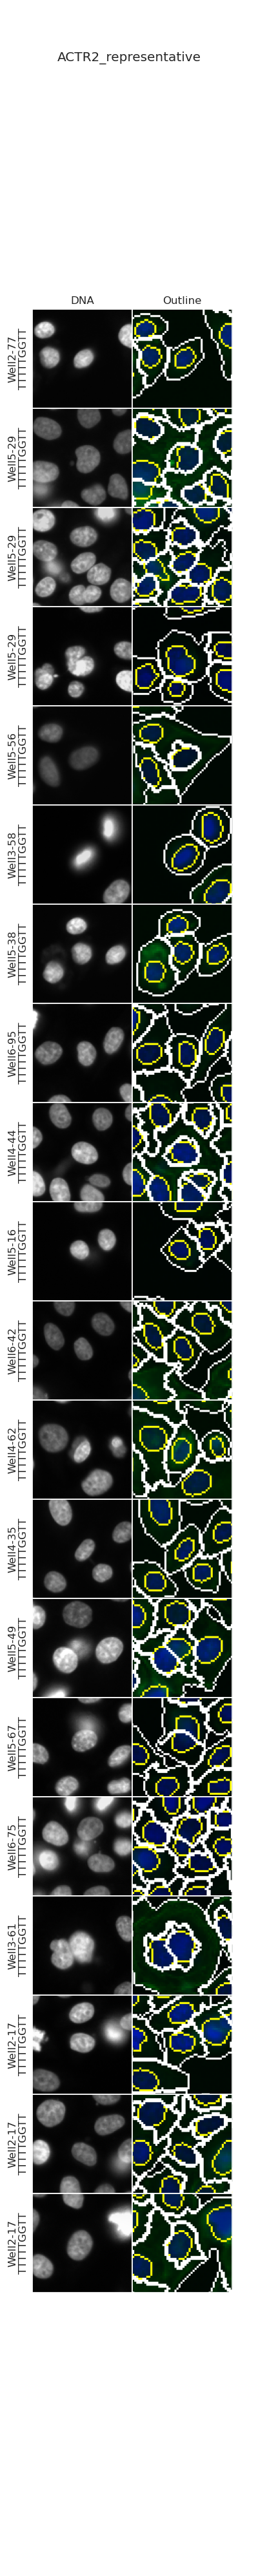

ACTR2_representative
ACTR2_representative
ACTR2_representative
ACTR2_representative
ACTR2_representative
ACTR3_representative
ACTR3_representative
ACTR3_representative
ACTR3_representative
ACTR3_representative
ARPC2_representative
ARPC2_representative
ARPC2_representative
ARPC2_representative
ARPC2_representative
ARPC3_representative


 /home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/utils/visualize_data.py:386: UserWarning:Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.


ARPC3_representative
ARPC3_representative


 /home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/utils/visualize_data.py:386: UserWarning:Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.


ARPC3_representative
ARPC3_representative


 /home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/utils/visualize_data.py:324: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


ATP6AP1_representative
ATP6AP1_representative
ATP6AP1_representative
ATP6AP1_representative
ATP6AP1_representative
ATP6V0D1_representative
ATP6V0D1_representative
ATP6V0D1_representative
ATP6V0D1_representative
ATP6V0D1_representative
TMEM251_representative
TMEM251_representative
TMEM251_representative
TMEM251_representative
TMEM251_representative
ALG12_representative
ALG12_representative
ALG12_representative
ALG12_representative
ALG12_representative
TUSC3_representative
TUSC3_representative
TUSC3_representative
TUSC3_representative
TUSC3_representative
FDPS_representative
FDPS_representative


 /home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/utils/visualize_data.py:386: UserWarning:Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.


FDPS_representative
FDPS_representative
FDPS_representative
ALG5_representative
ALG5_representative
ALG5_representative
ALG5_representative
ALG5_representative
DPAGT1_representative
DPAGT1_representative
DPAGT1_representative
DPAGT1_representative
DPAGT1_representative
ALG1_representative
ALG1_representative
ALG1_representative
ALG1_representative
ALG1_representative


In [2]:
import glob
rootDir='/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/'

# batch='20200805_A549_WG_Screen';
batch='20210422_6W_CP257';


batch_multi_name_dict={'20210422_6W_CP257':'CP257-HeLa-WG',\
                   '20200805_A549_WG_Screen':'CP186-A549-WG'}
batchName2=batch_multi_name_dict[batch]
sc_files_dir=rootDir+'workspace/software/'+batchName2+'/data/1.profiles/'+batch+'/single_cell/single_cell_by_guide/'
im_size=5500 # hardcoded for now, TODO: create a dictionary if this number is different for 257 vs 186

### metadata 
metadata_dir=rootDir+'workspace/metadata/'+batch+'/'
metadata_orig= pd.read_csv(metadata_dir+'Barcodes.csv')

# input_gene='KRT28'
n_cells=20
box_size=100

# how we select cells which can be 'random','representative','geometric_median'
cell_selection_method='representative'
channels=['DNA','Mito','Phalloidin','WGA','ER']

resultsDir='/home/ubuntu/bucket/projects/2018_11_20_Periscope_Calico/workspace/visualizations/'+batch+'/'+\
cell_selection_method+'_guide_level_channel_level/'


# genes_ls=metadata_orig.gene_symbol.unique().tolist()

genes_ls=['ACTR2','ACTR3','ARPC2','ARPC3','ATP6AP1',\
'ATP6V0D1','ATP6V1DALG1L','TMEM251','ALG12','TUSC3','FDPS','ALG5','DPAGT1','ALG1']

# Meraj_only_g_ls=['ACTR2','ACTR3','ARPC2','ARPC3','ARPC4','ATP6AP1','ATP6V0D1','ATP6V1DALG1L']

# genes_ls=['ACTR2','ACTR3','ARPC2','ARPC3','ARPC4','ATP6AP1','ATP6V0D1','ATP6V1DALG1L']
# genes_ls=['TOMM20']
# genes_ls=["nontargeting"]

for igi in range(len(genes_ls)):
    input_gene=genes_ls[igi]
    all_guides_gms_ls=[]
    gene_guids_ls=glob.glob(sc_files_dir+'*_'+input_gene+'.csv.gz')
    for gi in gene_guids_ls[-1:]:
        df_p_s=pd.read_csv(gi);
        
        for ch in channels:
            df_p_s["PathName_Corr"+ch]=rootDir+batch+'/images_corrected_cropped/'+df_p_s["Metadata_Foci_plate"]+'_'+df_p_s["Metadata_Foci_well"]+'/Corr'+ch
            df_p_s["FileName_Corr"+ch]="Corr"+ch+"_"+"Site_"+df_p_s["Metadata_Foci_site_location"].astype(str)+".tiff"

        df_p_s["Path_Outlines"]=rootDir+'workspace/analysis/'+batch+'/'+df_p_s["Metadata_Foci_plate"]+'-'+df_p_s["Metadata_Foci_well"]+'-'+df_p_s["Metadata_Foci_site_location"].astype(str)+'/'\
        +'/CorrDNA_Site_'+df_p_s["Metadata_Foci_site_location"].astype(str)+'_Overlay.png'

        df_p_s["Nuclei_Location_Center_X"]=df_p_s["Cells_AreaShape_Center_X"];
        df_p_s["Nuclei_Location_Center_Y"]=df_p_s["Cells_AreaShape_Center_Y"];
        
        df_p_s=edgeCellFilter2(df_p_s,im_size,box_size/2);
        
        #.sample(n = np.min([1500,df_p_s.shape[0]]),\
#         channel_name_in_feats=['DAPI_Painting','ConA','Mito','Phalloidin','WGA']
        align_column_ch_name_map={'DNA':'DAPI_Painting','ER':'ConA','Mito':'Mito','Phalloidin':'Phalloidin','WGA':'WGA'}
        
        if df_p_s.shape[0]>0:
            for ch in channels:
                channel_feats=df_p_s.columns[df_p_s.columns.str.contains('_'+align_column_ch_name_map[ch]+'|_X|_Y|FileName_|Path|Metadata_')]
                df_samples,cp_features_analysis = extract_single_cell_samples(df_p_s[channel_feats],n_cells,cell_selection_method);

                resdir=resultsDir+input_gene+'/'+gi.split('_')[-2]
                os.system("mkdir -p "+resdir)

        #             all_guides_gms_ls.append(df_samples)

        #         all_guides_gms_df=pd.concat(all_guides_gms_ls,ignore_index=True).drop_duplicates(ignore_index=True)

        #         if all_guides_gms_df.shape[0]==1:
        #             all_guides_gms_df=pd.concat([all_guides_gms_df]*2, ignore_index=True)    

                df_samples['label']=df_p_s["Metadata_Foci_well"]+'-'+df_p_s["Metadata_Foci_site_location"].astype(str)
#                 fig=visualize_n_SingleCell_pooled(channels,df_samples,box_size,im_size,title=input_gene+'_'+cell_selection_method);
                channels2=[ch,'Outline']
                fig=visualize_n_SingleCell_pooled(channels2,df_samples,box_size,im_size,title=input_gene+'_'+cell_selection_method);
                gc.collect()
            #     resultsDir='/home/ubuntu/bucket/projects/2018_11_20_Periscope_Calico/workspace/visualizations/'+batch+'/geometric_median_guide_level/'
                fig.savefig(resdir+'/'+ch+'.png',dpi=500)  
                plt.ioff()

In [33]:
# df_samples.shape
# np.power(2,16)
channels

['DNA', 'Mito', 'Phalloidin', 'WGA', 'ER', 'Outline']

In [16]:
df_samples.columns[df_samples.columns.str.contains('FileName')]

Index(['FileName_CorrDNA', 'FileName_CorrMito', 'FileName_CorrPhalloidin',
       'FileName_CorrWGA', 'FileName_CorrER', 'FileName_CorrOutline'],
      dtype='object')

In [19]:
df_p_s.columns.str.contains('_ConA')

array([False, False, False, ..., False, False, False])

In [4]:
ls /home/ubuntu/bucket/projects/2018_11_20_Periscope_Calico/workspace/visualizations/20210422_6W_CP257/representative_guide_level_channel_level/

OSError: [Errno 12] Cannot allocate memory